# Test Metrics
Notebook to conduct and display test metrics for malware NLP classification models. This notebook loads models and parameter weights previously trained in seperated training notebooks. 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os, gc
import numpy as np
import random
from tqdm import tqdm
import torch
%matplotlib inline

import json
import torch

with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(DATA_DIR, "model_data")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


RANDOM_SEED = 4321
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
DROPOUT = 0.25
LEARNING_RATE = 0.005
EMBEDDING_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LENGTH = 20480 * 2
HIDDEN_DIM = 256
NUM_LAYERS = 1
NUM_CLASSES = 4

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Set up CUDA debug environment

In [2]:
# Enable synchronous CUDA execution for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Enable device-side assertions in CUDA kernels
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Confirm the variables are set
print("CUDA_LAUNCH_BLOCKING =", os.getenv('CUDA_LAUNCH_BLOCKING'))
print("TORCH_USE_CUDA_DSA =", os.getenv('TORCH_USE_CUDA_DSA'))

CUDA_LAUNCH_BLOCKING = 1
TORCH_USE_CUDA_DSA = 1


### Load Data (already cleaned and selected)

In [3]:
from datasets import load_dataset

REPORT_DIR = os.path.join(DATA_DIR, "report_data")
os.makedirs(REPORT_DIR, exist_ok=True)

# get all files in the report directory
file_paths = [os.path.join(REPORT_DIR, f) for f in os.listdir(REPORT_DIR) if os.path.isfile(os.path.join(REPORT_DIR, f))]
print(file_paths)

dataset = load_dataset('json', data_files=file_paths)['train']
print(dataset)

['/media/mike/Data/gimc/classifier/report_data/json_0.json', '/media/mike/Data/gimc/classifier/report_data/json_1.json', '/media/mike/Data/gimc/classifier/report_data/json_10.json', '/media/mike/Data/gimc/classifier/report_data/json_11.json', '/media/mike/Data/gimc/classifier/report_data/json_12.json', '/media/mike/Data/gimc/classifier/report_data/json_13.json', '/media/mike/Data/gimc/classifier/report_data/json_14.json', '/media/mike/Data/gimc/classifier/report_data/json_15.json', '/media/mike/Data/gimc/classifier/report_data/json_2.json', '/media/mike/Data/gimc/classifier/report_data/json_3.json', '/media/mike/Data/gimc/classifier/report_data/json_4.json', '/media/mike/Data/gimc/classifier/report_data/json_5.json', '/media/mike/Data/gimc/classifier/report_data/json_6.json', '/media/mike/Data/gimc/classifier/report_data/json_7.json', '/media/mike/Data/gimc/classifier/report_data/json_8.json', '/media/mike/Data/gimc/classifier/report_data/json_9.json']
Dataset({
    features: ['text', 

### Split Data
Same split will used to test all models. The seed ensures this translate to the same hold outsamples from training (i.e. test samples were NEVER used for training). We will discard the training and validation samples.

In [4]:
# First, split into 80% train and 20% (validation + test), with shuffling
train_test_split = dataset.train_test_split(test_size=0.2, seed=RANDOM_SEED, shuffle=True)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

# Then, split the 20% temp_dataset into 10% validation and 10% test, with shuffling
validation_test_split = temp_dataset.train_test_split(test_size=0.5, seed=RANDOM_SEED, shuffle=True)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

# Check the size and order of samples in each split
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(validation_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 12800 samples
Validation dataset: 1600 samples
Test dataset: 1600 samples


### Load Tokenizer

In [5]:
tokenizer_path = os.path.join(DATA_DIR, 'model_data', 'mal-reformer')
print(f"Tokenizer path: {tokenizer_path}")

import torch
from transformers import AutoTokenizer, ReformerForSequenceClassification

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"

Tokenizer path: /media/mike/Data/gimc/classifier/model_data/mal-reformer


### Tokenizer Function

In [6]:
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

In [7]:
# Tokenize test dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

### Create Dataloaders

In [8]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)

def data_loader(test_dataset, batch_size=BATCH_SIZE):
    
    test_inputs = []
    test_labels = []    
    for i in tqdm(range(len(test_dataset)), desc="Tokenizing test dataset"):
        test_inputs.append(test_dataset[i]['input_ids'])
        test_labels.append(test_dataset[i]['label'])

    # Convert data type to torch.Tensor
    test_inputs = torch.tensor(test_inputs)
    test_labels = torch.tensor(test_labels)
                                   
    # create DataLoader for test data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return test_dataloader

In [9]:
test_dataloader = data_loader(tokenized_test_dataset)

Tokenizing test dataset: 100%|██████████| 1600/1600 [01:12<00:00, 22.20it/s]


### Model Evalution Function

In [10]:
# model evaluation function
from tqdm import tqdm
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    for i, batch in tqdm(enumerate(dataloader), desc="Evaluating model", total=len(dataloader)):
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(input_ids)
        predictions = torch.argmax(logits, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
    return y_true, y_pred


### BERT Evaluation

Trainable parameters: 2779855
Non-trainable parameters: 0
Loaded checkpoint from /media/mike/Data/gimc/classifier/model_data/bert4mal_checkpoint.pth. Model trainined for 15epochs


Evaluating model: 100%|██████████| 50/50 [06:10<00:00,  7.41s/it]


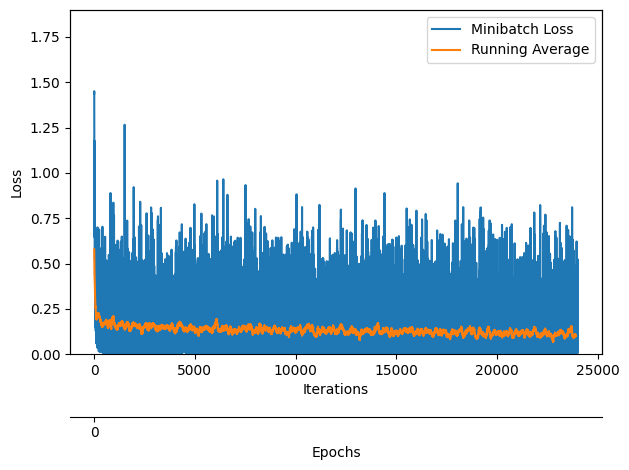

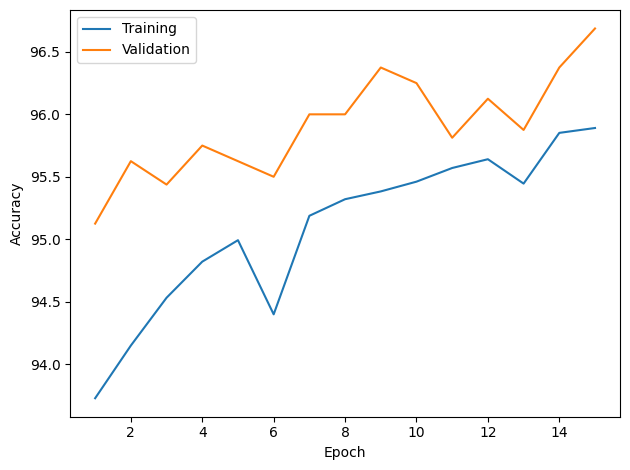

                precision    recall  f1-score   support

    AgentTesla     0.8884    0.9590    0.9224       415
RedLineStealer     0.9536    0.8747    0.9124       399
RaccoonStealer     1.0000    1.0000    1.0000       388
        benign     1.0000    1.0000    1.0000       398

      accuracy                         0.9581      1600
     macro avg     0.9605    0.9584    0.9587      1600
  weighted avg     0.9595    0.9581    0.9580      1600



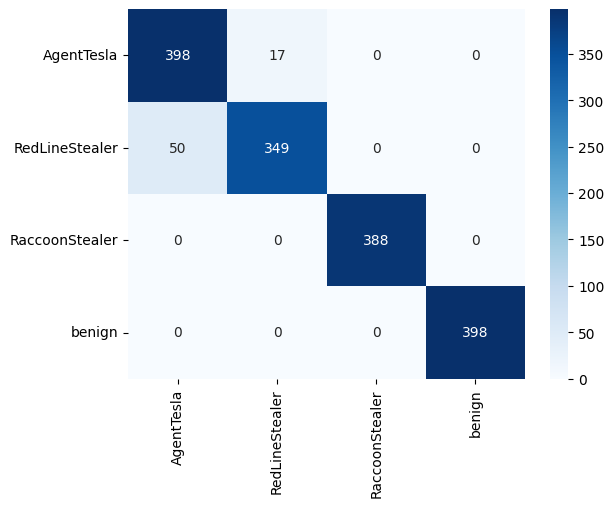

In [14]:
from models.transformer_classifier import TransformerClassifier
# Load the model
model = TransformerClassifier(
    nhead=4,  # the number of heads in the multiheadattention models
    dim_feedforward=25,  # the dimension of the feedforward network model in nn.TransformerEncoder
    num_layers=3,
    dropout=0.0,
    classifier_dropout=0.0,
    num_classes=NUM_CLASSES,
    max_length=MAX_LENGTH,
    vocab_size=VOCABULARY_SIZE
).to(DEVICE)

# Count the number of trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Load the model checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'bert4mal_checkpoint.pth')
checkpoint = torch.load(checkpoint_path)
# MUST USE OLD STYLE CHECKPOINT
model.load_state_dict(checkpoint['model_state_dict'])
print(f'Loaded checkpoint from {checkpoint_path}. Model trainined for {checkpoint['epoch']}epochs')

# evaluate the model
y_true, y_pred = evaluate_model(model, test_dataloader, DEVICE)

# display training loss and accuracy from checkpoint
minibatch_loss_list = checkpoint['minibatch_loss_list']
train_acc_list = checkpoint['train_acc_list']
valid_acc_list = checkpoint['valid_acc_list']

from utils.plot import plot_accuracy, plot_training_loss
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataset),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)


# find precision, recall, f1-score, and accuracy. Additionally, plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
SIGNATURES = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=SIGNATURES, yticklabels=SIGNATURES)
print(classification_report(y_true, y_pred, target_names=SIGNATURES, digits=4))


### LSTM Evaluation

/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Trainable parameters: 2956292
Non-trainable parameters: 0
Loaded checkpoint from /media/mike/Data/gimc/classifier/model_data/lstm4mal_checkpoint.pth. Model trainined for 15 epochs


Evaluating model: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


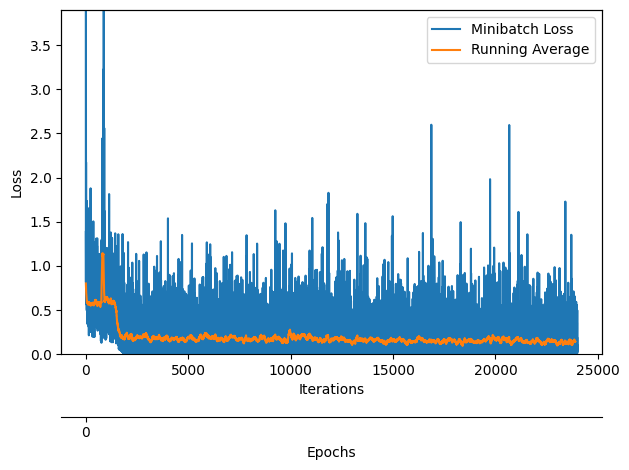

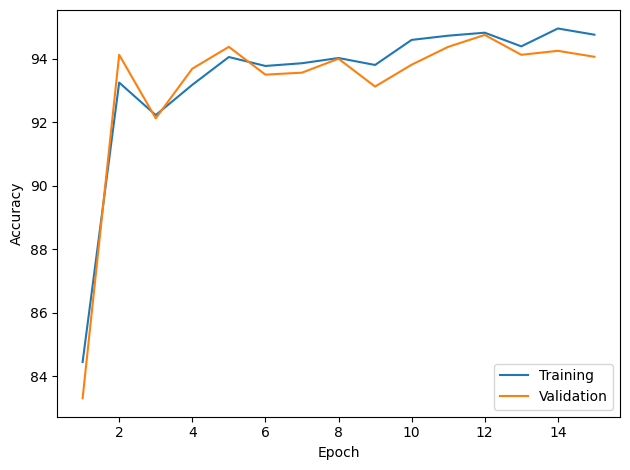

                precision    recall  f1-score   support

    AgentTesla     0.8776    0.9325    0.9042       415
RedLineStealer     0.9249    0.8647    0.8938       399
RaccoonStealer     0.9974    0.9974    0.9974       388
        benign     0.9975    0.9975    0.9975       398

      accuracy                         0.9475      1600
     macro avg     0.9493    0.9480    0.9482      1600
  weighted avg     0.9483    0.9475    0.9474      1600



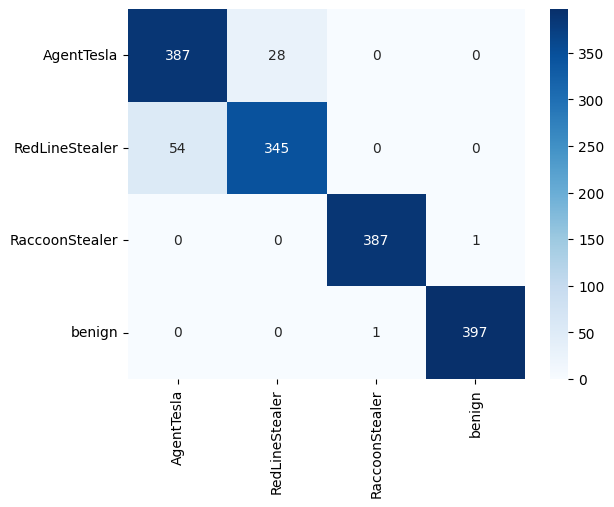

In [15]:
from models.lstm import LSTMClassifier

# Initialize the LSTM model
model = LSTMClassifier(vocab_size=VOCABULARY_SIZE,
                        embed_dim=EMBEDDING_DIM,
                        hidden_dim=HIDDEN_DIM,
                        num_layers=NUM_LAYERS,
                        num_class=NUM_CLASSES,
                        dropout=DROPOUT).to(DEVICE)

# Count the number of trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Load the model checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'lstm4mal_checkpoint.pth')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_states'][-1])
print(f'Loaded checkpoint from {checkpoint_path}. Model trainined for {len(checkpoint["model_states"])} epochs')

# evaluate the model
y_true, y_pred = evaluate_model(model, test_dataloader, DEVICE)

# display training loss and accuracy from checkpoint
minibatch_loss_list = checkpoint['minibatch_loss_list']
train_acc_list = checkpoint['train_acc_list']
valid_acc_list = checkpoint['valid_acc_list']

from utils.plot import plot_accuracy, plot_training_loss
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataset),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

# find precision, recall, f1-score, and accuracy. Additionally, plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
SIGNATURES = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=SIGNATURES, yticklabels=SIGNATURES)
print(classification_report(y_true, y_pred, target_names=SIGNATURES, digits=4))

### CNN Evaluation

Trainable parameters: 2575514
Non-trainable parameters: 0
Loaded checkpoint from /media/mike/Data/gimc/classifier/model_data/cnn4mal_checkpoint.pth. Model trainined for 15epochs


Evaluating model:   0%|          | 0/50 [00:00<?, ?it/s]/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
Evaluating model: 100%|██████████| 50/50 [00:02<00:00, 20.22it/s]


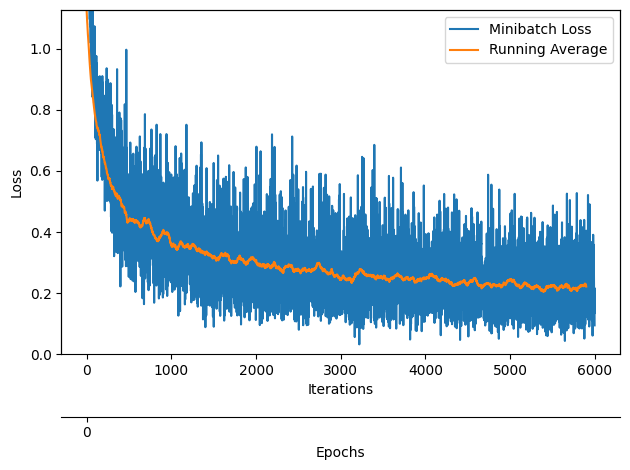

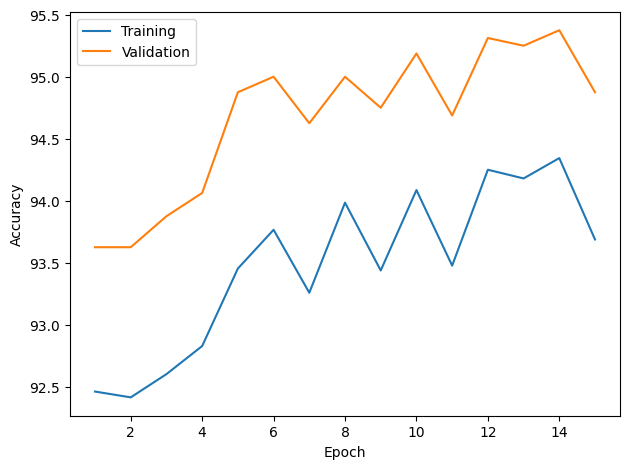

                precision    recall  f1-score   support

    AgentTesla     0.8300    0.9880    0.9021       415
RedLineStealer     0.9843    0.7870    0.8747       399
RaccoonStealer     1.0000    1.0000    1.0000       388
        benign     0.9975    1.0000    0.9987       398

      accuracy                         0.9437      1600
     macro avg     0.9529    0.9437    0.9439      1600
  weighted avg     0.9514    0.9437    0.9430      1600



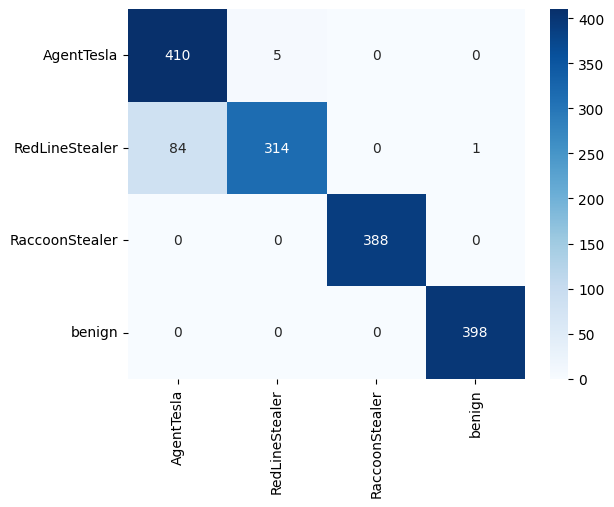

In [16]:
from models.lstm import LSTMClassifier

from models.cnn_nlp import CNN_NLP
# Instantiate CNN model
VOCABULARY_SIZE = 20_000
LEARNING_RATE = 0.05
EMBEDDING_DIM = 128
DROPOUT = 0.5
FILTER_SIZES=[3, 4, 5]
NUM_FILTERS=[10, 10, 10]
model = CNN_NLP(
                    vocab_size=VOCABULARY_SIZE,
                    embed_dim=EMBEDDING_DIM,
                    filter_sizes=FILTER_SIZES,
                    num_filters=NUM_FILTERS,
                    num_classes=NUM_CLASSES,
                    dropout=DROPOUT).to(DEVICE)

# Count the number of trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Load the model checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'cnn4mal_checkpoint.pth')
checkpoint = torch.load(checkpoint_path)
# MUST USE OLD STYLE CHECKPOINT
model.load_state_dict(checkpoint['model_state_dict'])
print(f'Loaded checkpoint from {checkpoint_path}. Model trainined for {checkpoint['epoch']}epochs')

# evaluate the model
y_true, y_pred = evaluate_model(model, test_dataloader, DEVICE)

# display training loss and accuracy from checkpoint
minibatch_loss_list = checkpoint['minibatch_loss_list']
train_acc_list = checkpoint['train_acc_list']
valid_acc_list = checkpoint['valid_acc_list']

from utils.plot import plot_accuracy, plot_training_loss
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataset),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

# find precision, recall, f1-score, and accuracy. Additionally, plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
SIGNATURES = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=SIGNATURES, yticklabels=SIGNATURES)
print(classification_report(y_true, y_pred, target_names=SIGNATURES, digits=4))

### MLP Evaluation

Trainable parameters: 2791173
Non-trainable parameters: 0
Loaded checkpoint from /media/mike/Data/gimc/classifier/model_data/mlp4mal_checkpoint.pth. Model trainined for 15epochs


Evaluating model: 100%|██████████| 50/50 [00:00<00:00, 159.46it/s]


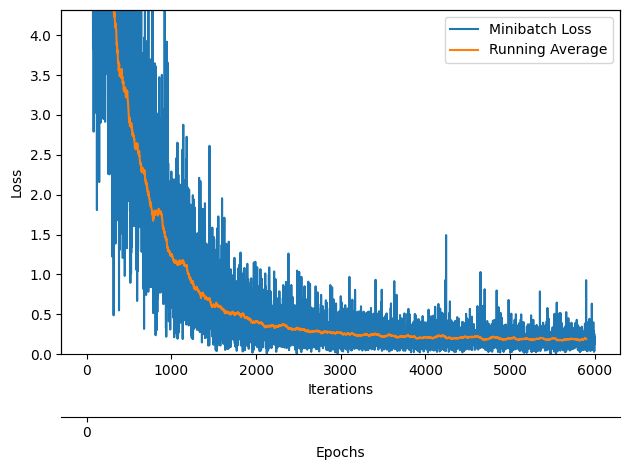

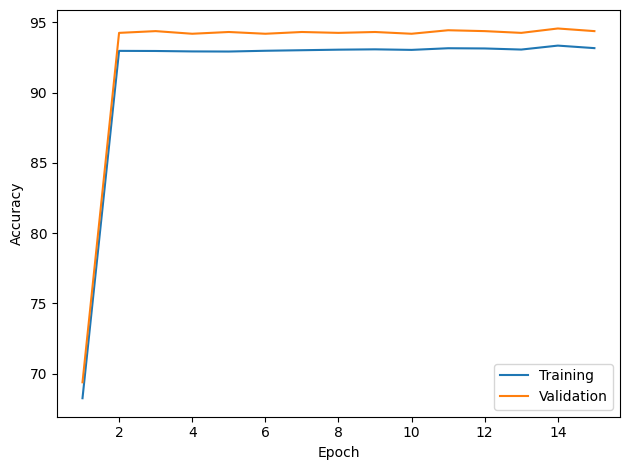

                precision    recall  f1-score   support

    AgentTesla     0.8121    1.0000    0.8963       415
RedLineStealer     1.0000    0.7594    0.8632       399
RaccoonStealer     1.0000    1.0000    1.0000       388
        benign     1.0000    1.0000    1.0000       398

      accuracy                         0.9400      1600
     macro avg     0.9530    0.9398    0.9399      1600
  weighted avg     0.9513    0.9400    0.9390      1600



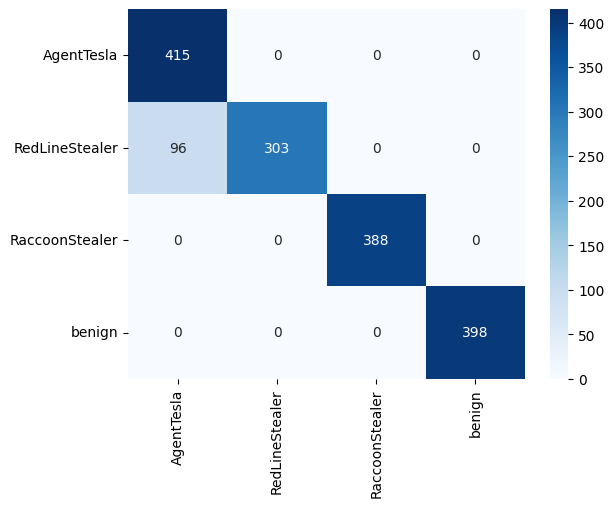

In [17]:
from models.mlp_nlp import MLP_NLP
EMBEDDING_DIM = 128
model = MLP_NLP(vocab_size=VOCABULARY_SIZE,
                embed_dim=EMBEDDING_DIM,
                num_class=NUM_CLASSES,
                hidden_size1=513,
                hidden_size2=256,
                hidden_size3=128,
                dropout=DROPOUT).to(DEVICE)

# Count the number of trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Load the model checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'mlp4mal_checkpoint.pth')
checkpoint = torch.load(checkpoint_path)
# MUST USE OLD STYLE CHECKPOINT
model.load_state_dict(checkpoint['model_state_dict'])
print(f'Loaded checkpoint from {checkpoint_path}. Model trainined for {checkpoint['epoch']}epochs')

# evaluate the model
y_true, y_pred = evaluate_model(model, test_dataloader, DEVICE)

# display training loss and accuracy from checkpoint
minibatch_loss_list = checkpoint['minibatch_loss_list']
train_acc_list = checkpoint['train_acc_list']
valid_acc_list = checkpoint['valid_acc_list']

from utils.plot import plot_accuracy, plot_training_loss
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataset),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

# find precision, recall, f1-score, and accuracy. Additionally, plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
SIGNATURES = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=SIGNATURES, yticklabels=SIGNATURES)
print(classification_report(y_true, y_pred, target_names=SIGNATURES, digits=4))